#### 1.0 Importing data and relevant libraies:

In [1]:
##Pre processing libs:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

##Modelling libs:
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

"""Defining function for downloading data into current session. 
Go to Kaggle > Account > Get API token, if token not stated."""

def getdata(APItoken):
  os.environ['KAGGLE_USERNAME'] = "nikolajtrampedach"
  os.environ['KAGGLE_KEY'] = APItoken
  try:
    !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    !unzip gtsrb-german-traffic-sign.zip
    print('********** Downloading and unzipping completed **********')
  except: 
    print('************ An error occured while loading ************')

In [ ]:
# Downloading data with the Kaggle API token
getdata('***INSERT YOUR OWN APITOKEN***')

#### 2.0 Data Processing


In [3]:
#Defining lable names:
ClassDict = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
#Only needed if we want to reduce the total number of classes to speed limit signs

#train = train[(train['ClassId'] <= 8)] 
#test = test[(test['ClassId'] <= 8)]

In [5]:
#First, we investigate the average image size prior to resizing the images.
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

print('The average train width of images is: {}'.format(train['Width'].mean()))
print('The average train height of images is: {}\n'.format(train['Height'].mean()))

print('The average test width of images is: {}'.format(test['Width'].mean()))
print('The average test height of images is: {}'.format(test['Height'].mean()))

The average train width of images is: 50.83587951745773
The average train height of images is: 50.328929582493814

The average test width of images is: 50.50775930324624
The average test height of images is: 50.36444972288203


In [6]:
#Mapping all class instances with the respectfully name in Classdict

train["class_nm"] = train["ClassId"].map(ClassDict)
test["class_nm"] = test["ClassId"].map(ClassDict)

Test reference: 11901
Class name: Speed limit (100km/h)



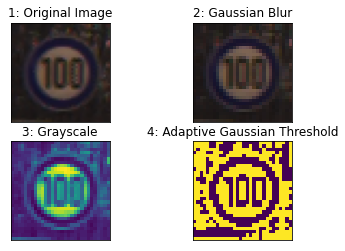

In [7]:
#plotting an visual example of the four stages in the image processing

random_int = random.randint(1,31367)
step = 1

#img_org = image.load_img(train['Path'][random_int],target_size=(49,49,4), interpolation = True)
img_org = cv2.imread((train['Path'][random_int]),-1)
img = cv2.resize(img_org, (30,30))
#img = image.img_to_array(img_org)
img_blur = cv2.GaussianBlur(img, (49, 49), 0.01).astype('uint8')
img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)#imshow do not work with RGB2GRAY, so this is only needed to plot grayscale img.
img_thresh_Gaussian = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)

print('Test reference: {}'.format(random_int))
print('Class name: {}\n'.format(train["class_nm"][random_int]))

titles = ['1: Original Image', '2: Gaussian Blur', 
          '3: Grayscale', '4: Adaptive Gaussian Threshold']
image_list = (img_org,img_blur,img_gray,img_thresh_Gaussian)

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(image_list[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

##### Function not working -- do not return assigned results

#####   

In [9]:
#Building training data
data_list = []
for i in tqdm(range(train.shape[0])):
  img_org = cv2.imread(train['Path'][i],-1)
  img = cv2.resize(img_org, (30,30))
  #img_blur = cv2.GaussianBlur(img, (49, 49), 0.01).astype('uint8')
  #img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)#imshow do not work with RGB2GRAY, so this is only needed to plot grayscale img.
  #img_thresh_Gaussian = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
  data_list.append(img) #Appending each image to data_list
X = np.array(data_list) #/ 255.00 #Scaling pizels from range(0-255) to range (0.0-1.0)
y = np.array(train['ClassId'])


100%|██████████| 39209/39209 [00:07<00:00, 5484.13it/s]


In [10]:
#Building test data
data_list = []
for i in tqdm(range(test.shape[0])):
  img_org = cv2.imread(test['Path'][i],-1)
  img = cv2.resize(img_org, (30,30))
  #img_blur = cv2.GaussianBlur(img, (49, 49), 0.01).astype('uint8')
  #img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)#imshow do not work with RGB2GRAY, so this is only needed to plot grayscale img.
  #img_thresh_Gaussian = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
  data_list.append(img) #Appending each image to data_list        
X_test = np.array(data_list) #/ 255.00 #Scaling pizels from range(0-255) to range (0.0-1.0)
y_test = np.array(test['ClassId'])

100%|██████████| 12630/12630 [00:02<00:00, 5371.89it/s]


In [11]:
"""In order to have a validation dataset, we split the X and y derived from the train folder in to train and validation
Hence, the image dir folder is ordered, we include shuffle = True in the train_test_split to ensure all classes are represented """

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, shuffle = True, random_state=1)

instances = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]

print('Total instances of data available: {}\n'.format(instances))
print('Shape of X_train: {}  -  {:.1f} pct.'.format(X_train.shape,X_train.shape[0]/instances*100))
print('Shape of X_val:   {}   -  {:.1f} pct.'.format(X_val.shape,X_val.shape[0]/instances*100))
print('Shape of X_test:  {}  -  {:.1f} pct.'.format(X_test.shape,X_test.shape[0]/instances*100))

Total instances of data available: 51839

Shape of X_train: (31367, 30, 30, 3)  -  60.5 pct.
Shape of X_val:   (7842, 30, 30, 3)   -  15.1 pct.
Shape of X_test:  (12630, 30, 30, 3)  -  24.4 pct.


In [12]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

#### 3.0 Data Exploration

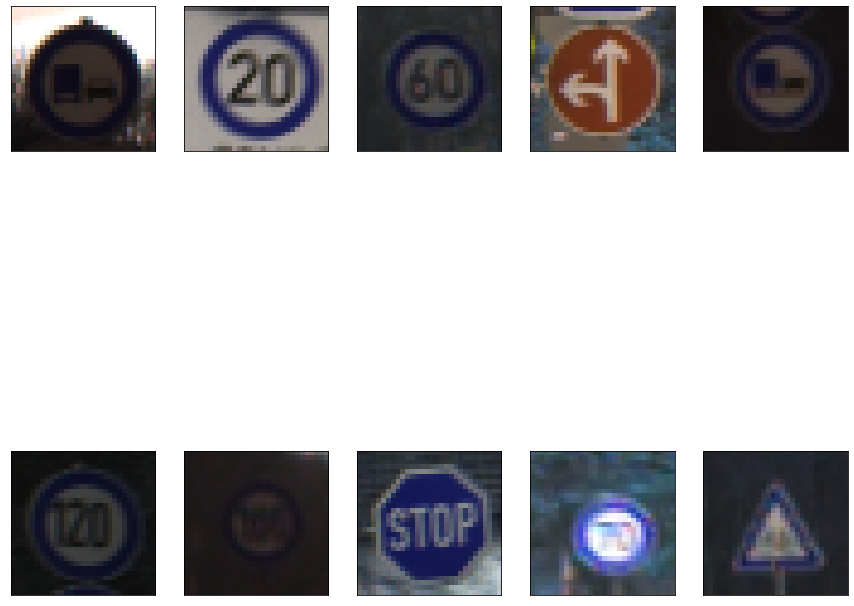

In [13]:
#Plotting 10 random images
fig, axs = plt.subplots(figsize=(15, 15))
for i in range(0,10):
  random_int = random.randint(1,31367)
  plt.subplot(2,5,i+1),plt.imshow(X_train[random_int])
  #plt.title(y_train[random_int])
  plt.xticks([]),plt.yticks([])
plt.show()

#### 4.0 Modelling

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [16]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (30,30,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(43, activation= 'softmax'))

# model compilation
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

In [18]:
epochs = 15
history = model.fit(X_train, y_train, 
                   batch_size=64,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

Epoch 1/15
491/491 [==============================] - 125s 253ms/step - loss: 4.0634 - accuracy: 0.2217 - val_loss: 0.8340 - val_accuracy: 0.7716
Epoch 2/15
491/491 [==============================] - 123s 250ms/step - loss: 1.1283 - accuracy: 0.6688 - val_loss: 0.4950 - val_accuracy: 0.8893
Epoch 3/15
491/491 [==============================] - 125s 255ms/step - loss: 0.7749 - accuracy: 0.7703 - val_loss: 0.4083 - val_accuracy: 0.8713
Epoch 4/15
491/491 [==============================] - 122s 249ms/step - loss: 0.6875 - accuracy: 0.7965 - val_loss: 0.2135 - val_accuracy: 0.9382
Epoch 5/15
491/491 [==============================] - 122s 248ms/step - loss: 0.5638 - accuracy: 0.8283 - val_loss: 0.1592 - val_accuracy: 0.9528
Epoch 6/15
491/491 [==============================] - 123s 250ms/step - loss: 0.4886 - accuracy: 0.8527 - val_loss: 0.1401 - val_accuracy: 0.9580
Epoch 7/15
491/491 [==============================] - 122s 249ms/step - loss: 0.3502 - accuracy: 0.8919 - val_loss: 0.1901 -

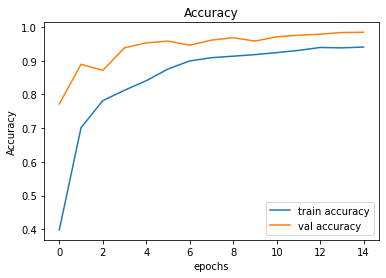

In [19]:
plt.figure(0)
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

Test reference: 4653

Prediction class: 8
Actual: Speed limit (120km/h)


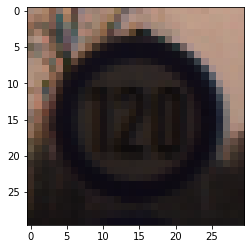

In [20]:
random_int = random.randint(1,12630)
plt.imshow(X_test[random_int])

predictions = model.predict(np.expand_dims(X_test[random_int], axis=0))
classes = np.argmax(predictions)
print('Test reference: {}\n'.format(random_int))
print('Prediction class: {}'.format(classes))
print('Actual: {}'.format(list(ClassDict.values())[list(ClassDict.keys()).index(classes)]))